In [1]:
%matplotlib inline
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# import catboost as cb
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import Pool

In [2]:
# !pip install catboost

In [3]:
hp_df = pd.read_csv('BA1hydro_HeatpulseFM_7MAY_run9_pass1_picktime_and_flow_values.txt',skiprows=1)

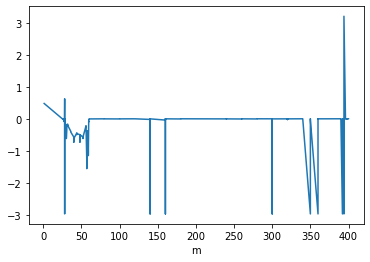

In [4]:
ax=hp_df.set_index('m')['Gal./min.'].plot()

<AxesSubplot:xlabel='m'>

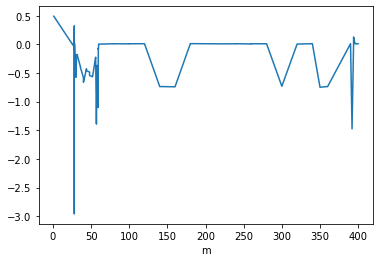

In [5]:
gb = hp_df.groupby('m')
gb.mean()['Gal./min.'].plot()

In [6]:
flows = gb.mean().reset_index()
flows.columns = ['depth', 's', 'flowrate'] # Gallons/minute
flows

,depth,s,flowrate
0,1.13538,0.95000,0.490107
1,25.99140,34.57500,-0.009195
2,25.99180,45.94750,-0.006870
3,26.51580,33.20000,0.007283
4,26.99530,26.95000,0.009035
...,...,...,...
75,394.00300,0.30000,0.127810
76,396.00100,28.81744,0.008743
77,398.00100,25.70000,0.009754
78,400.00000,27.65000,0.008793


In [7]:
lithdf = pd.read_excel('Dataset_BA1A.xlsx')
lithdf.head()

,TOP_DEPTH,LAG_DEPTH,UNIT_CLASS,MUD_TYPE,UNIT_DESC3_1,UNIT_DESC3_3,UNIT_DESC3_4,REMARKS_1,REMARKS_2,REMARKS_3,...,UNIT_DESC4_2_Cutting Rock Type: Gabbro::Cutting Minerals: Serpentine,UNIT_DESC4_2_Cutting Rock Type: Harzburgite,UNIT_DESC4_2_Cutting Rock Type: Harzburgite::Cutting Minerals: Carbonate,UNIT_DESC4_2_Cutting Rock Type: Harzburgite::Cutting Minerals: Carbonate; Orthopyroxene; Serpentine,UNIT_DESC4_2_Cutting Rock Type: Harzburgite::Cutting Minerals: Carbonate; Serpentine,UNIT_DESC4_2_Cutting Rock Type: Harzburgite::Cutting Minerals: Orthopyroxene,UNIT_DESC4_2_Cutting Rock Type: Harzburgite::Cutting Minerals: Serpentine,UNIT_DESC4_2_Cutting Rock Type: Harzburgite; Alluvium::Cutting Minerals: Serpentine,UNIT_DESC4_2_Cutting Rock Type: Harzburgite; Serpentinite::,UNIT_DESC4_2_Cutting Rock Type: Serpentinite
0,0,15,OPHIO,CU,Cutting Rock Type: Harzburgite::,NaN,NaN,NN,NN,NN,...,0,0,0,0,0,0,0,0,0,0
1,15,16,OPHIO,CU,Cutting Rock Type: Harzburgite; Alluvium::,NaN,NaN,NN,NN,NN,...,0,0,0,0,0,0,0,0,0,0
2,16,17,OPHIO,CU,Cutting Rock Type: Harzburgite; Alluvium::,NaN,NaN,Dominantly partially serpentinized Harzburgite,NN,NN,...,0,0,0,0,0,0,0,0,0,0
3,17,18,OPHIO,CU,Cutting Rock Type: Harzburgite; Alluvium::,NaN,NaN,Dominantly paratially serpentinized harzburgite,NN,NN,...,0,0,0,0,0,0,0,0,0,0
4,18,19,OPHIO,CU,Cutting Rock Type: Harzburgite,Cutting Minerals: Serpentine,NaN,NN,NN,serpentine veins,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# lithdf.sum(axis=0)
lithdf.sum()
'UNIT_DESC4_2_Cutting Minerals: Serpentine'

/tmp/ipykernel_23656/927888300.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lithdf.sum()


'UNIT_DESC4_2_Cutting Minerals: Serpentine'

In [47]:
df = pd.read_csv('mldata.csv')

# this finds the closet depth to this depth
df['flowrate'] = df.depth.apply(lambda d: flows['flowrate'].iloc[np.abs(flows.depth.values - d).argmin()])

df['serpentine'] = df.depth.apply(lambda d: lithdf['UNIT_DESC4_2_Cutting Minerals: Serpentine'].iloc[np.abs(lithdf.TOP_DEPTH - d).argmin()])

df['rocktype'] = df.depth.apply(lambda d: lithdf['UNIT_DESC3_1'].iloc[np.abs(lithdf.TOP_DEPTH - d).argmin()])
df['rocktype'] = df['rocktype'].astype('category')

df = df[df.depth.between(100, 420)]

df.reset_index(drop=True, inplace=True)

df.sort_values('tn', inplace=True)

# df['ones'] = 1

df['tn'] = pd.to_datetime(df['tn'])

df.describe()

,tn-1,tn+1,depth,maxamp,swarm_n,cummaxamp,cumtime,depthdiff,flowrate,serpentine
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,3.570652,3.653415,272.044471,4.935448,1.810204,2735.157635,2382.917145,0.262103,-0.175556,0.957143
std,16.684277,18.344548,63.167373,17.998357,0.872729,2034.006030,1200.067236,33.082060,0.322068,0.202558
min,0.000001,0.000001,103.500000,0.101230,1.000000,0.259065,8.738000,-280.875000,-0.748852,0.000000
25%,0.446000,0.446000,219.000000,0.594587,1.000000,1085.649657,1512.761250,-0.875000,0.004457,1.000000
50%,0.663000,0.660999,267.125000,1.330682,2.000000,2203.662213,2445.800000,0.000000,0.008486,1.000000
75%,1.258000,1.252500,328.156250,3.682804,2.000000,3863.624413,3198.128250,0.875000,0.010394,1.000000
max,579.597001,579.597001,414.125000,557.253460,4.000000,8443.321285,6094.117999,392.875000,0.011873,1.000000


In [91]:
# df['Date'] = df.index

data_for_catboost = df.groupby(['swarm_n', pd.Grouper(key = 'tn', freq='30s')]).mean().fillna(0).reset_index()

# std = df.groupby(['swarm_n', pd.Grouper(key = 'tn', freq='30s')]).std().fillna(0).reset_index()

# data_for_catboost = data_for_catboost.join(std, lsuffix='_avg', rsuffix='_std')

# max = df.groupby(['swarm_n', pd.Grouper(key = 'tn', freq='30s')]).max().fillna(0).reset_index()
# data_for_catboost = data_for_catboost.join(max, rsuffix='_max')

In [92]:
data_for_catboost.corr()

,swarm_n,tn-1,tn+1,depth,maxamp,cummaxamp,cumtime,depthdiff,flowrate,serpentine
swarm_n,1.000000,0.134395,0.135490,-0.145451,0.382977,-0.191987,0.017781,-0.005222,0.021115,0.172208
tn-1,0.134395,1.000000,0.295577,-0.189669,-0.053050,-0.224310,-0.137741,-0.063610,-0.155106,0.027752
tn+1,0.135490,0.295577,1.000000,-0.098078,-0.074253,-0.194831,0.016768,-0.261860,-0.111378,0.063438
depth,-0.145451,-0.189669,-0.098078,1.000000,-0.004766,0.705173,0.617483,0.133211,-0.343068,-0.090511
maxamp,0.382977,-0.053050,-0.074253,-0.004766,1.000000,0.261748,-0.246632,0.049547,0.035327,0.072791
cummaxamp,-0.191987,-0.224310,-0.194831,0.705173,0.261748,1.000000,0.145310,0.083248,-0.196596,-0.098220
cumtime,0.017781,-0.137741,0.016768,0.617483,-0.246632,0.145310,1.000000,-0.053974,-0.189935,-0.028285
depthdiff,-0.005222,-0.063610,-0.261860,0.133211,0.049547,0.083248,-0.053974,1.000000,-0.076041,-0.023942
flowrate,0.021115,-0.155106,-0.111378,-0.343068,0.035327,-0.196596,-0.189935,-0.076041,1.000000,-0.146025
serpentine,0.172208,0.027752,0.063438,-0.090511,0.072791,-0.098220,-0.028285,-0.023942,-0.146025,1.000000


max lag: 188


198

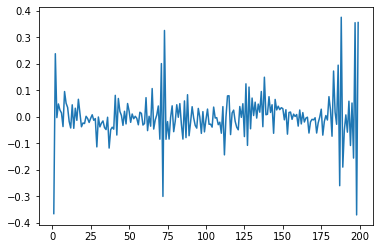

In [124]:
acs = []
lags = np.arange(1, 200, 1)
for n in lags:
    ac = data_for_catboost['depthdiff'].autocorr(lag=n)
    acs.append(ac)
    
acs = np.array(acs)
fig, ax = plt.subplots()
ax.plot(lags, acs)
print('max lag:',lags[np.argmax(acs)])
np.max(np.where(acs>0.20))

In [114]:
idx = 1250
df.iloc[idx-24:idx]

# TODO: Make a function that creates new columns based on a lag value
#.      and adds them to the dataframe inplace

def get_autoregressive_vals(df, idx, col, lags):
    # ar_df = df.iloc[idx-lags:idx][col]
    # # print(ar_df.shape)
    # if ar_df.values.shape[0] == 0:
    #     return np.zeros(lags)+np.nan
    # else:
    #     return ar_df.values
    if idx < lags:
        return np.zeros(lags)+np.nan
    else:
        return df.iloc[idx-lags:idx][col]
    
def get_autoregressive_cols(df, lags, col):
    vals = np.zeros([df.shape[0], lags])
    for idx in df.index:
        ar_val = get_autoregressive_vals(df=df, idx=idx, col=col, lags=lags)
        vals[idx] += ar_val
    return pd.DataFrame(vals, columns=[f'{col}_lag_{lag+1}' for lag in range(lags)])

def make_df_with_ar_cols(df, col, lags):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    df_ar = get_autoregressive_cols(df=df, lags=lags, col=col)
    return df.join(df_ar)

lags = 20
# df_1 = df[df.swarm_n==1].join(get_autoregressive_cols(df=df[df.swarm_n==1], lags=lags, col='maxamp'))
df_1 = make_df_with_ar_cols(df=data_for_catboost[data_for_catboost.swarm_n==1], lags=lags, col='maxamp')
df_2 = make_df_with_ar_cols(df=data_for_catboost[data_for_catboost.swarm_n==2], lags=lags, col='maxamp')
df_3 = make_df_with_ar_cols(df=data_for_catboost[data_for_catboost.swarm_n==3], lags=lags, col='maxamp')
df_4 = make_df_with_ar_cols(df=data_for_catboost[data_for_catboost.swarm_n==4], lags=lags, col='maxamp')

data_for_catboost = pd.concat([df_1, df_2, df_3, df_4])
# df_2.describe()
# df_1.describe()

In [115]:
data_for_catboost.columns

Index(['swarm_n', 'tn', 'tn-1', 'tn+1', 'depth', 'maxamp', 'cummaxamp',
       'cumtime', 'depthdiff', 'flowrate', 'serpentine', 'maxamp_lag_1',
       'maxamp_lag_2', 'maxamp_lag_3', 'maxamp_lag_4', 'maxamp_lag_5',
       'maxamp_lag_6', 'maxamp_lag_7', 'maxamp_lag_8', 'maxamp_lag_9',
       'maxamp_lag_10', 'maxamp_lag_11', 'maxamp_lag_12', 'maxamp_lag_13',
       'maxamp_lag_14', 'maxamp_lag_15', 'maxamp_lag_16', 'maxamp_lag_17',
       'maxamp_lag_18', 'maxamp_lag_19', 'maxamp_lag_20'],
      dtype='object')

In [125]:
# data_for_catboost.copy()

# Generate sample data
# x_columns = ['tn-1', 'depth', 'maxamp', 'swarm_n', 'cummaxamp',
x_columns = ['tn-1', 'depth', 'swarm_n', 'cummaxamp', 'maxamp',
       'cumtime', 'depthdiff', 'flowrate', 'serpentine']
x_columns = ['tn-1', 'depth', 'maxamp', 'cummaxamp',
       'cumtime', 'depthdiff', 'flowrate', 'serpentine', 'maxamp_lag_1',
       'maxamp_lag_2', 'maxamp_lag_3', 'maxamp_lag_4', 'maxamp_lag_5',
       'maxamp_lag_6', 'maxamp_lag_7', 'maxamp_lag_8', 'maxamp_lag_9',
       'maxamp_lag_10', 'maxamp_lag_11', 'maxamp_lag_12', 'maxamp_lag_13',
       'maxamp_lag_14', 'maxamp_lag_15', 'maxamp_lag_16', 'maxamp_lag_17',
       'maxamp_lag_18', 'maxamp_lag_19', 'maxamp_lag_20']
y_column = 'tn+1'
# y_column = 'maxamp'
X_train =data_for_catboost[data_for_catboost.swarm_n.isin([1, 2, 3])][x_columns]
y_train =data_for_catboost[data_for_catboost.swarm_n.isin([1, 2, 3])][y_column]
X_test = data_for_catboost[data_for_catboost.swarm_n.isin([4,])][x_columns]
y_test = data_for_catboost[data_for_catboost.swarm_n.isin([4,])][y_column]

# Create CatBoost pools
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Define CatBoost parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    'loss_function': 'RMSE',
    'verbose': False,
    # 'objective':'Poisson',
    'has_time':True
}

# Train the CatBoost model
model = cb.CatBoostRegressor(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)

# Make predictions
y_pred_train = model.predict(train_pool)
y_pred_test = model.predict(test_pool)

# Model evaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

# Plot feature importance
feature_importance = model.get_feature_importance()
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']

# plt.barh(feature_names, feature_importance)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
feature_importance


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train MSE: 990.7181272210513
Test MSE: 154.17869954069675
Train MAE: 13.072052231885563
Test MAE: 10.349317865931846
Train R^2: 0.5034469045480734
Test R^2: 0.10196481807633928


array([12.18636461,  4.09987836,  4.97712151,  2.43404725,  3.89782474,
       30.55354337,  5.06514209,  0.37900883,  1.57630077,  1.34109018,
        1.79532452,  0.90374014,  2.02157542,  2.76141751,  1.78230254,
        1.08277203,  1.9274036 ,  2.00627445,  1.38638346,  1.39914325,
        1.91058001,  2.02344818,  1.47808322,  2.78909722,  1.54480662,
        2.62008943,  2.49864394,  1.55859273])

In [123]:
for x, f in zip(x_columns, feature_importance):
    print(x, f)

tn-1 12.963031686422685
depth 4.459613806502368
maxamp 7.3085467548362955
cummaxamp 0.7718415732815821
cumtime 0.3761753693952276
depthdiff 35.5863412402474
flowrate 2.620993239475912
serpentine 0.303780642455857
maxamp_lag_1 1.2381303699943285
maxamp_lag_2 2.5812771802142227
maxamp_lag_3 1.9631343641320547
maxamp_lag_4 0.0
maxamp_lag_5 2.4919397614321834
maxamp_lag_6 4.465000860480812
maxamp_lag_7 1.2395351689336327
maxamp_lag_8 0.05395486074052477
maxamp_lag_9 2.766711430960616
maxamp_lag_10 3.141040350491596
maxamp_lag_11 1.6918659710510233
maxamp_lag_12 0.10021422289467201
maxamp_lag_13 2.4150171115577086
maxamp_lag_14 1.19084471669905
maxamp_lag_15 1.7871636928829266
maxamp_lag_16 2.5643555612953017
maxamp_lag_17 1.342718460241129
maxamp_lag_18 2.8200713962393307
maxamp_lag_19 1.0074275708490332
maxamp_lag_20 0.7492726362925624


In [120]:
x = np.arange(0, 9, 1)
browns = x/(x.max()*2)

x2 = np.arange(1, 12, 1)
purples = x2/(x2.max()*2) + 0.5

x_combined = np.hstack([browns[:-1], purples])
x_combined

array([0.        , 0.0625    , 0.125     , 0.1875    , 0.25      ,
       0.3125    , 0.375     , 0.4375    , 0.54545455, 0.59090909,
       0.63636364, 0.68181818, 0.72727273, 0.77272727, 0.81818182,
       0.86363636, 0.90909091, 0.95454545, 1.        ])

(0.0, 20.0)

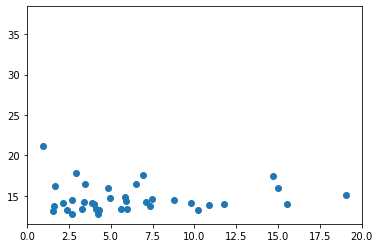

In [121]:
y_pred_test
y_test.values
fig, ax = plt.subplots()

ax.scatter(y_test.values, y_pred_test)
ax.set_xlim(0, 20)

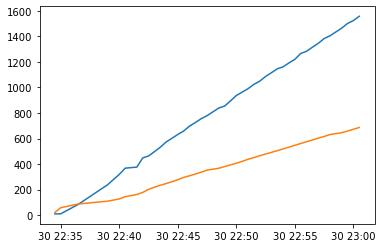

In [122]:
fig, ax = plt.subplots()
# data = df[df['swarm_n']==4].copy()
data = data_for_catboost[data_for_catboost['swarm_n']==4].copy()
x = pd.to_datetime(data['tn'])

ax.plot(x, data.cumtime)
ax.plot(x, y_pred_test.cumsum())

<AxesSubplot:>

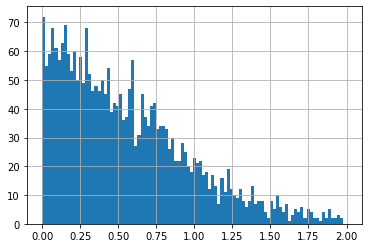

In [26]:
df.maxamp.apply(np.log10).hist(bins=np.linspace(0, 2,100))

In [19]:
df

,tn-1,tn,tn+1,depth,maxamp,swarm_n,cummaxamp,cumtime,depthdiff,flowrate,serpentine,rocktype
0,10.204,2019-05-21 07:38:57.152000,3.180000,184.000,0.285077,1,0.285077,10.204,0.000,0.011873,1,Cutting Rock Type: Harzburgite
1,3.180,2019-05-21 07:38:57.607000,0.455000,170.875,7.151964,1,7.437041,13.384,-13.125,0.008532,1,Cutting Rock Type: Harzburgite
2,0.455,2019-05-21 07:39:00.080000,2.473000,171.750,43.556691,1,50.993732,13.839,0.875,0.008532,1,Cutting Rock Type: Harzburgite
3,2.473,2019-05-21 07:39:00.926000,0.846000,170.875,81.321380,1,132.315111,16.312,-0.875,0.008532,1,Cutting Rock Type: Harzburgite
4,0.846,2019-05-21 07:39:07.065001,6.139001,170.875,2.485894,1,134.801006,17.158,0.000,0.008532,1,Cutting Rock Type: Harzburgite
...,...,...,...,...,...,...,...,...,...,...,...,...
4405,2.662,2019-07-30 23:00:11.177999,10.801000,379.125,36.376443,4,8184.572344,1521.846,140.000,0.010894,1,Cutting Rock Type: Harzburgite
4406,10.801,2019-07-30 23:00:27.113999,15.936000,380.000,1.537374,4,8186.109718,1532.647,0.875,0.010894,1,Cutting Rock Type: Harzburgite
4407,15.936,2019-07-30 23:00:36.726999,9.613000,387.875,0.245740,4,8186.355457,1548.583,7.875,0.010894,1,Cutting Rock Type: Harzburgite
4408,9.613,2019-07-30 23:00:46.209999,9.483000,379.125,24.298655,4,8210.654112,1558.196,-8.750,0.010894,1,Cutting Rock Type: Harzburgite


In [20]:
# Generate sample data
x_columns = [  'tn-1'
             , 'depth'
             , 'tn+1'
             , 'swarm_n'
             # , 'cummaxamp',
             , 'cumtime'
             , 'depthdiff'
             , 'flowrate'
             , 'serpentine'
             , 'rocktype']
y_column = 'maxamp'
X_train = df[df.swarm_n.isin([1, 2, 3])][x_columns]
y_train = df[df.swarm_n.isin([1, 2, 3])][y_column]
X_test = df[df.swarm_n.isin([4,])][x_columns]
y_test = df[df.swarm_n.isin([4,])][y_column]

# Create CatBoost pools
train_pool = Pool(X_train, y_train, cat_features=['rocktype',])
test_pool = Pool(X_test, y_test, cat_features=['rocktype',])

# Define CatBoost parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 10,
    # 'loss_function': 'RMSE',
    'verbose': False,
    'objective':'Poisson',
    'has_time':True
}

# Train the CatBoost model
model = cb.CatBoostRegressor(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)

# Make predictions
y_pred_train = model.predict(train_pool)
y_pred_test = model.predict(test_pool)

# Model evaluation
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

# Plot feature importance
feature_importance = model.get_feature_importance()
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']

# plt.barh(feature_names, feature_importance)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
feature_importance


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train MSE: 37.26504790809025
Test MSE: 4875.171780408408
Train MAE: 2.3035651687534755
Test MAE: 31.27952936531961
Train R^2: 0.3556478342168973
Test R^2: -0.2421254675262381


array([11.86923299, 14.66699196, 14.46503979, 13.17511361, 13.12635274,
       11.44617991, 13.37608207,  1.30455582,  6.57045112])